In [74]:
# Main
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Modelling
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from fbprophet import Prophet
pd.plotting.register_matplotlib_converters()

import sys
sys.path.append("../models")

In [75]:
from prophet_forecaster import ProphetForecaster

In [76]:
def flatten(x):
    return [z for y in x for z in y ]

In [77]:
def plot_grid(df, n_cols, figsize):
    n_rows = int(np.ceil(len(df.columns)/n_cols))
    df.plot(subplots=True, layout=(n_rows, n_cols), figsize=figsize)

In [78]:
def plot_fcst(fcst, train=None, test=None):
    ax = fcst.yhat.plot()
    lower = fcst.yhat_lower.interpolate()
    upper = fcst.yhat_upper.interpolate()
    plt.fill_between(fcst.index, y1=lower, y2=upper, alpha=0.3)
    if train is not None:
        train.plot(style="k.")
    if test is not None:
        test.plot(style="r.")

In [79]:
plt.rcParams["figure.figsize"] = (14,4)

In [80]:
data = pd.read_csv("../data/base_limpia.csv", parse_dates=["tiempo", "fecha pedido", "fecha liq"])

In [81]:
data.head()

,tiempo,nro factura,cliente,categoria,tipo negocio,localidad,direccion,plaza/campaña,producto,nro pedido,...,u pedidas,kg pedidos,fecha liq,u entregadas,kg entregados,importe bruto,importe factura,sucursal,longitud,latitud
0,2017-05-29,93315173,200008870.0,a5,mayorista,santa fe,av del valle 7199,plaza,90746,2736812,...,1,1.250,2017-05-29,1,1.250,231.70,12421.88,santa fe,-60.691979,-31.602638
1,2017-06-14,93368453,200008870.0,a5,mayorista,santa fe,av del valle 7199,plaza,90746,2765668,...,1,1.250,2017-06-14,1,1.250,231.70,19944.84,santa fe,-60.691979,-31.602638
2,2017-02-21,93074208,200008889.0,a3,supermercado,santa fe,gral.paz 5374,plaza,90740,2546672,...,2,1.464,2017-02-21,2,1.464,324.96,24534.07,santa fe,-60.686356,-31.620964
3,2017-05-11,93270490,200008889.0,a3,supermercado,santa fe,gral.paz 5374,plaza,90746,2702464,...,1,1.250,2017-05-11,1,1.250,231.70,27204.63,santa fe,-60.686356,-31.620964
4,2017-05-24,93309184,200008889.0,a3,supermercado,santa fe,gral.paz 5374,plaza,90746,2732609,...,1,1.250,2017-05-24,1,1.250,231.70,16573.12,santa fe,-60.686356,-31.620964


In [82]:
u_producto = pd.pivot_table(data, values="u pedidas", index="tiempo", columns="producto", aggfunc="sum").asfreq("D")

In [83]:
u_producto.head()

producto,16034,16061,16062,16070,16071,16075,16076,16077,16080,16081,...,44151,44152,44154,44155,44157,44158,90739,90740,90745,90746
tiempo,,,,,,,,,,,,,,,,,,,,,
2017-01-02,NaN,7.0,1.0,25.0,11.0,3.0,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,1.0,NaN,NaN,4.0,1.0,NaN,NaN
2017-01-03,NaN,21.0,NaN,27.0,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0,NaN,NaN
2017-01-04,NaN,NaN,NaN,8.0,4.0,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN
2017-01-05,NaN,3.0,NaN,6.0,3.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,10.0,NaN,1.0,NaN,1.0,NaN,NaN
2017-01-06,NaN,NaN,2.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


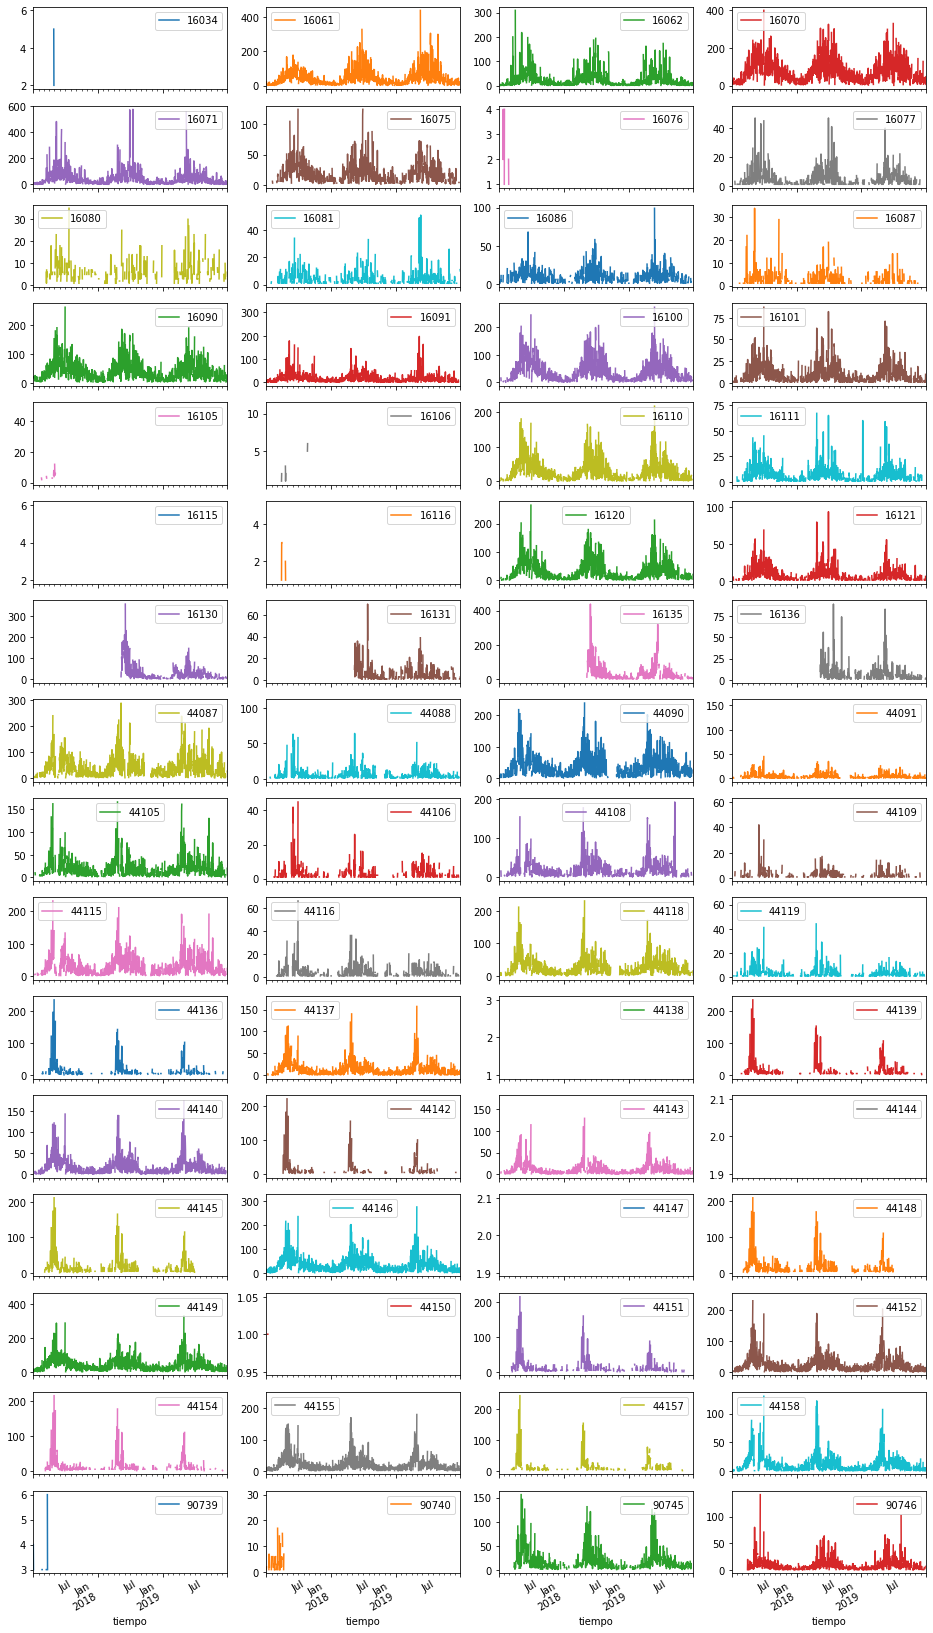

In [84]:
plot_grid(u_producto, n_cols=4, figsize=(16,32))

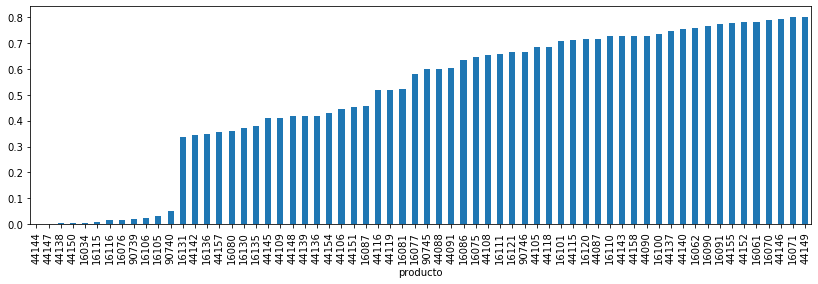

In [85]:
amount_info = (u_producto.notna()).sum() / len(u_producto)
amount_info.sort_values().plot(kind="bar")

In [86]:
T = 0.5
forecastable = (amount_info > T)
u_producto_forecastable = u_producto.loc[:, forecastable]

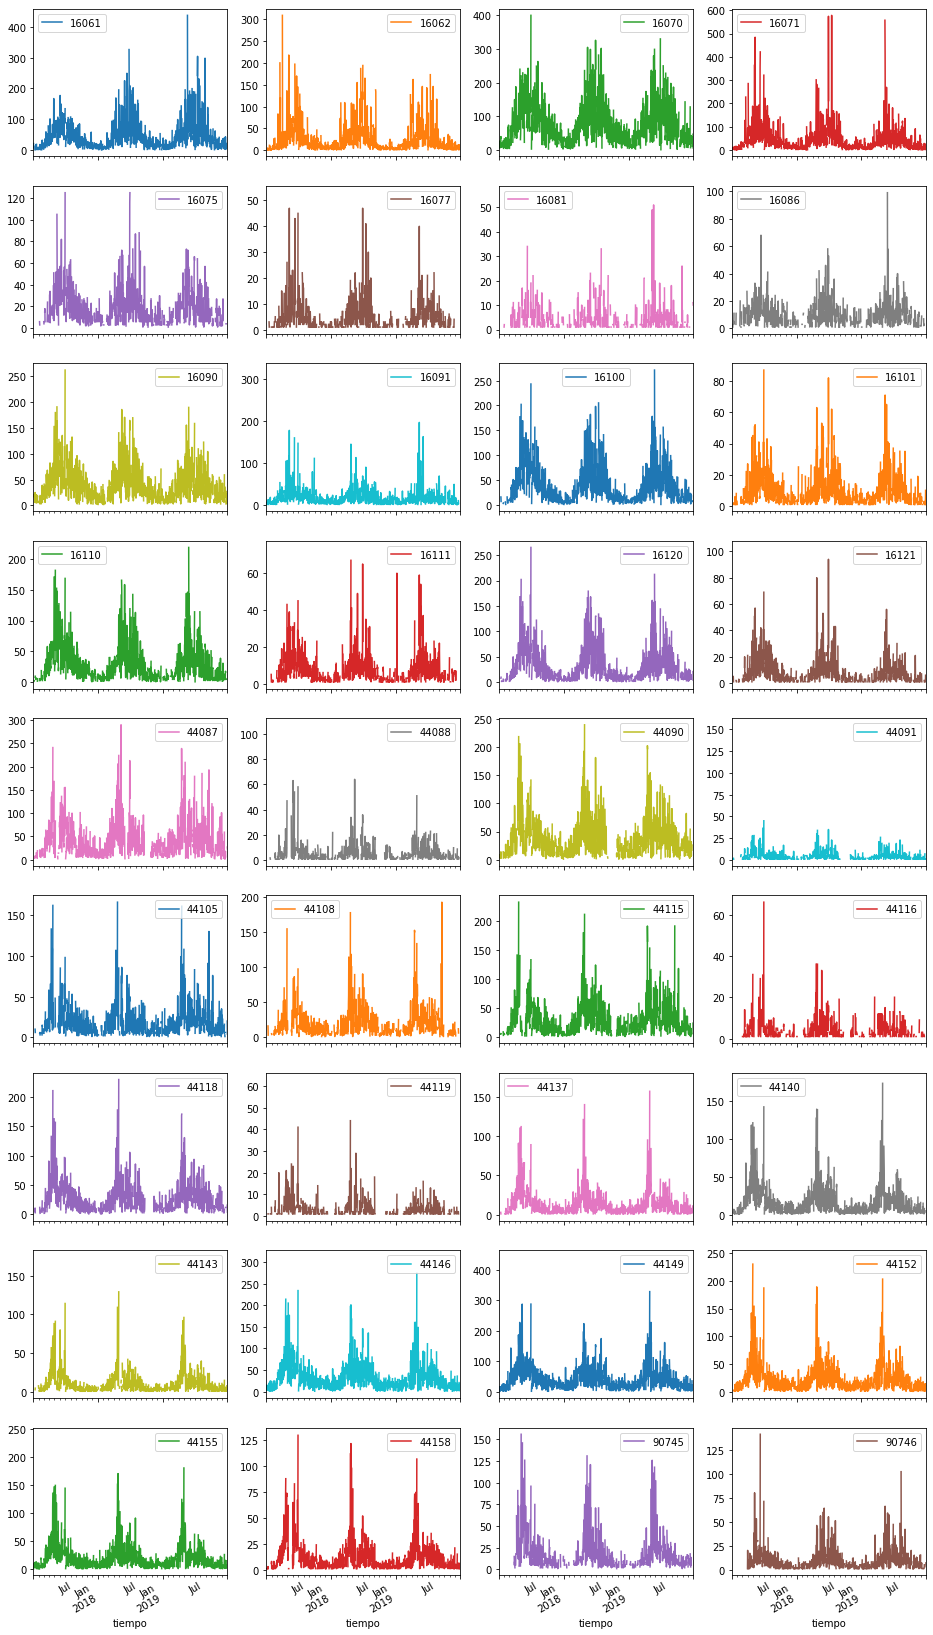

In [87]:
plot_grid(u_producto_forecastable, n_cols=4, figsize=(16, 32))

In [88]:
train, test = u_producto_forecastable[:"2018-12-31"], u_producto_forecastable["2019-01-01":]

In [89]:
model = ProphetForecaster()
model.fit(train)
fcst = model.predict(steps=365).asfreq("D")

In [92]:
fcst

16061                            16062                       \
           yhat_lower       yhat yhat_upper yhat_lower      yhat yhat_upper   
ds                                                                            
2017-01-02   2.309139   7.607071  21.304919   0.701822  2.512892   8.592538   
2017-01-03   2.049982   7.654909  21.597436        NaN       NaN        NaN   
2017-01-04        NaN        NaN        NaN        NaN       NaN        NaN   
2017-01-05   2.206291   7.752082  22.496570        NaN       NaN        NaN   
2017-01-06        NaN        NaN        NaN   0.755577  2.673500   8.710112   
...               ...        ...        ...        ...       ...        ...   
2019-12-25   3.235209  10.716725  27.307376   0.710035  2.488887   8.144519   
2019-12-26   3.057280  10.525543  27.441454   0.690397  2.469021   7.580618   
2019-12-27   3.141718  10.378421  26.355647   0.665862  2.456496   7.773294   
2019-12-28   2.949036  10.272711  26.550715   0.718905  2.451180   7.566665   
2019-12-29   2.964115  10.205128  27.204008   0.682182  2.452855   7.878760   

                16070                            16071  ...      44155  \
           yhat_lower       yhat yhat_upper yhat_lower  ... yhat_upper   
ds                                                      ...              
2017-01-02   5.492159  18.884722  51.221984   2.156094  ...  11.846707   
2017-01-03   5.268800  18.470171  47.175081   2.001839  ...        NaN   
2017-01-04   5.344100  18.134397  44.242461   1.772260  ...  11.493513   
2017-01-05   4.780803  17.872691  44.703907   1.896558  ...  12.246880   
2017-01-06   5.743438  17.679571  44.585332        NaN  ...        NaN   
...               ...        ...        ...        ...  ...        ...   
2019-12-25   6.202483  20.925896  54.906741   2.051208  ...  14.991719   
2019-12-26   6.545958  19.969640  46.386996   1.461461  ...  15.050614   
2019-12-27   4.989897  19.070389  49.574849   1.593043  ...  13.791251   
2019-12-28   5.078516  18.235193  45.632880   1.813386  ...  14.044541   
2019-12-29   4.827799  17.469185  46.248057   1.503775  ...  13.034170   

                44158                           90745                       \
           yhat_lower      yhat yhat_upper yhat_lower      yhat yhat_upper   
ds                                                                           
2017-01-02        NaN       NaN        NaN        NaN       NaN        NaN   
2017-01-03        NaN       NaN        NaN        NaN       NaN        NaN   
2017-01-04   0.702402  1.942407   5.559412        NaN       NaN        NaN   
2017-01-05   0.753950  1.938956   5.131543        NaN       NaN        NaN   
2017-01-06        NaN       NaN        NaN        NaN       NaN        NaN   
...               ...       ...        ...        ...       ...        ...   
2019-12-25   0.908625  2.567147   7.729166   2.131624  5.576518  14.347625   
2019-12-26   0.832673  2.433485   6.805242   2.255528  5.535441  14.407362   
2019-12-27   0.845346  2.310059   6.171199   2.188174  5.468727  13.332061   
2019-12-28   0.739134  2.198004   6.230877   2.357361  5.377874  14.195521   
2019-12-29   0.762738  2.098068   5.731137   2.150523  5.265341  13.036636   

                90746                       
           yhat_lower      yhat yhat_upper  
ds                                          
2017-01-02        NaN       NaN        NaN  
2017-01-03        NaN       NaN        NaN  
2017-01-04        NaN       NaN        NaN  
2017-01-05        NaN       NaN        NaN  
2017-01-06        NaN       NaN        NaN  
...               ...       ...        ...  
2019-12-25   0.855312  2.261637   6.287637  
2019-12-26   0.805074  2.306740   6.186901  
2019-12-27   0.918214  2.357033   6.065472  
2019-12-28   0.907370  2.412286   6.502308  
2019-12-29   0.864467  2.472205   6.908389  

[1092 rows x 108 columns]

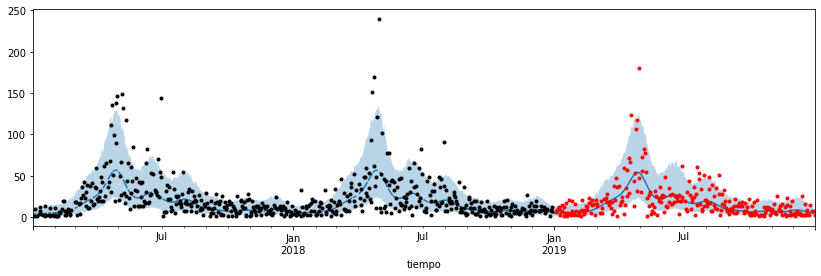

In [95]:
item = 44155
plot_fcst(fcst[item], train[item], test[item])